### Learning rate scheduler 추가
### Loss graph 추가
### Early stoping 추가
### Model save & load 추가

## Import

In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Transformer
import math



In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available() 

True

## Hyperparameter Setting

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':100,
    'PREDICT_SIZE':21,
    'EPOCHS':1000,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [5]:
train_data = pd.read_csv('../LGAimers/train.csv').drop(columns=['ID', '제품'])

### 데이터 전처리

In [6]:
# Data Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train_data))):
    maxi = np.max(train_data.iloc[idx,4:])
    mini = np.min(train_data.iloc[idx,4:])
    
    if maxi == mini :
        train_data.iloc[idx,4:] = 0
    else:
        train_data.iloc[idx,4:] = (train_data.iloc[idx,4:] - mini) / (maxi - mini)
    
    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

  0%|          | 0/15890 [00:00<?, ?it/s]

In [7]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [8]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [9]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [10]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [11]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [12]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4360216, 100, 5),
 (4360216, 21),
 (1090054, 100, 5),
 (1090054, 21),
 (15890, 100, 5))

### Custom Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [14]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

In [15]:
class BaseModel(nn.Module):
    # def __init__(self, input_size=5, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
    def __init__(self, input_size=5, hidden_size=512, output_size= 21):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )
            
        self.actv = nn.ReLU()
    
    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

In [16]:
class AttentionModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, output_size=21):
        super(AttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)  # Attention layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Attention mechanism
        attention_scores = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_lstm_out = lstm_out * attention_weights
        context_vector = torch.sum(weighted_lstm_out, dim=1)
        
        # Fully connected layer
        output = self.actv(self.fc(context_vector))
        
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))


### Best model save & load

In [17]:
def save(ckpt_dir, net, optim, epoch, best=False):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    if best:
        torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
                   os.path.join(ckpt_dir, "model_best.pth"))
    else:
        torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
                   os.path.join(ckpt_dir, "model_epoch%d.pth" % epoch))

def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst = [f for f in ckpt_lst if f.endswith(".pth")]
    ckpt_lst = sorted(ckpt_lst, key=lambda f: int(''.join(filter(str.isdigit, f.split(".")[0]))) if f.split(".")[0].isdigit() else -1)

    if not ckpt_lst:
        epoch = 0
        return net, optim, epoch

    dict_model = torch.load(os.path.join(ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    
    # 파일명에서 epoch 추출 시 예외 처리
    try:
        epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])
    except IndexError:
        epoch = 0

    return net, optim, epoch


### 모델 학습

In [18]:

def train(model, optimizer, train_loader, val_loader, device, ckpt_dir):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    st_epoch = 0
    model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, net=model, optim=optimizer)
    
    # Early stoping
    patience_limit = 10
    patience_check = 0
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-6)
    
    for epoch in range(st_epoch + 1, CFG['EPOCHS'] + 1):  # st_epoch + 1부터 시작
        model.train()
        train_loss = []
        train_mae = []
        
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')
        print(f'Patience : [{patience_check}] lr : [{optimizer.param_groups[0]["lr"]:.8f}]')
        
        Train_loss.append(np.mean(train_loss))
        Valid_loss.append(val_loss)
        
        scheduler.step(val_loss)  # 학습률 스케줄러에 검증 손실 전달

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            patience_check = 0
            print('Model Saved')
            save(ckpt_dir=ckpt_dir, net = best_model, optim = optimizer, epoch = epoch, best=True)
        else:
            patience_check += 1  # 손실이 개선되지 않으면 참을성 카운터 증가

        if patience_check >= patience_limit:  # 조기 종료 조건이 충족되면 학습종료         
            break
    
    return best_model

In [19]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [20]:
Train_loss = []
Valid_loss = []

In [21]:
model = AttentionModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
ckpt_dir = ("../LGAimers/ckpt")
infer_model = train(model, optimizer, train_loader, val_loader, device, ckpt_dir)

  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.03008] Val Loss : [0.02957]
Patience : [0] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.02785] Val Loss : [0.03008]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.02214] Val Loss : [0.02108]
Patience : [1] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01941] Val Loss : [0.02372]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01859] Val Loss : [0.01837]
Patience : [1] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01843] Val Loss : [0.02455]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01829] Val Loss : [0.01806]
Patience : [1] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01825] Val Loss : [0.01815]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01817] Val Loss : [0.01861]
Patience : [1] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01807] Val Loss : [0.01784]
Patience : [2] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.01796] Val Loss : [0.01779]
Patience : [0] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.01793] Val Loss : [0.01797]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.01777] Val Loss : [0.01752]
Patience : [1] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.01775] Val Loss : [0.01743]
Patience : [0] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.01777] Val Loss : [0.01754]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.01771] Val Loss : [0.01880]
Patience : [1] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.01762] Val Loss : [0.01801]
Patience : [2] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.01756] Val Loss : [0.01754]
Patience : [3] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.01753] Val Loss : [0.01714]
Patience : [4] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.01748] Val Loss : [0.01724]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.01745] Val Loss : [0.01772]
Patience : [1] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.01746] Val Loss : [0.01731]
Patience : [2] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.01742] Val Loss : [0.02175]
Patience : [3] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.01745] Val Loss : [0.01710]
Patience : [4] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.01732] Val Loss : [0.01705]
Patience : [0] lr : [0.00010000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.01734] Val Loss : [0.01747]
Patience : [0] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.01727] Val Loss : [0.01855]
Patience : [1] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.01724] Val Loss : [0.01730]
Patience : [2] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.01724] Val Loss : [0.01759]
Patience : [3] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.01720] Val Loss : [0.01716]
Patience : [4] lr : [0.00010000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.01710] Val Loss : [0.01699]
Patience : [5] lr : [0.00005000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.01709] Val Loss : [0.01688]
Patience : [0] lr : [0.00005000]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.01708] Val Loss : [0.01692]
Patience : [0] lr : [0.00005000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.01707] Val Loss : [0.01726]
Patience : [1] lr : [0.00005000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.01705] Val Loss : [0.01695]
Patience : [2] lr : [0.00005000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.01705] Val Loss : [0.01780]
Patience : [3] lr : [0.00005000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.01703] Val Loss : [0.01700]
Patience : [4] lr : [0.00005000]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.01699] Val Loss : [0.01685]
Patience : [5] lr : [0.00002500]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.01698] Val Loss : [0.01711]
Patience : [0] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.01698] Val Loss : [0.01694]
Patience : [1] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.01697] Val Loss : [0.01694]
Patience : [2] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.01697] Val Loss : [0.01684]
Patience : [3] lr : [0.00002500]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.01696] Val Loss : [0.01683]
Patience : [0] lr : [0.00002500]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.01696] Val Loss : [0.01680]
Patience : [0] lr : [0.00002500]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.01695] Val Loss : [0.01687]
Patience : [0] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.01695] Val Loss : [0.01691]
Patience : [1] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.01694] Val Loss : [0.01707]
Patience : [2] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.01694] Val Loss : [0.01684]
Patience : [3] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.01693] Val Loss : [0.01682]
Patience : [4] lr : [0.00002500]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.01691] Val Loss : [0.01678]
Patience : [5] lr : [0.00001250]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.01690] Val Loss : [0.01672]
Patience : [0] lr : [0.00001250]
Model Saved


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.01690] Val Loss : [0.01681]
Patience : [0] lr : [0.00001250]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.01690] Val Loss : [0.01679]
Patience : [1] lr : [0.00001250]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.01689] Val Loss : [0.01680]
Patience : [2] lr : [0.00001250]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.01689] Val Loss : [0.01677]
Patience : [3] lr : [0.00001250]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.01688] Val Loss : [0.01681]
Patience : [4] lr : [0.00001250]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.01687] Val Loss : [0.01673]
Patience : [5] lr : [0.00000625]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.01687] Val Loss : [0.01692]
Patience : [6] lr : [0.00000625]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.01687] Val Loss : [0.01675]
Patience : [7] lr : [0.00000625]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.01687] Val Loss : [0.01680]
Patience : [8] lr : [0.00000625]


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.01687] Val Loss : [0.01672]
Patience : [9] lr : [0.00000625]


## Loss graph

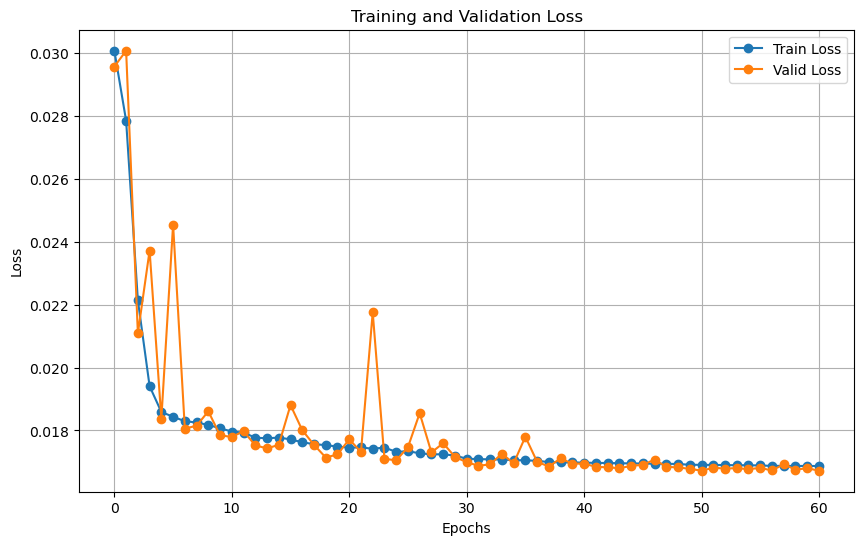

In [22]:
# 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정  
plt.plot(Train_loss, label='Train Loss', marker='o')  # Train_loss에 대한 그래프 그리기
plt.plot(Valid_loss, label='Valid Loss', marker='o')  # Valid_loss에 대한 그래프 그리기
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()  # 범례 추가
plt.grid()  # 그리드 추가
plt.show()  # 그래프 보이기

## 모델 추론

In [31]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [32]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [33]:
pred = inference(infer_model, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [35]:
pred.shape

(15890, 21)

## Submission

In [36]:
submit = pd.read_csv('../LGAimers/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,1
3,3,0,0,0,0,0,0,0,1,1,...,1,1,1,1,1,2,1,1,2,2
4,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [38]:
submit.to_csv('../LGAimers/baseline_submit.csv', index=False)